# AgentReview

In this tutorial, we explore simulating peer review using the AgentReview framework.

📑 Venue: EMNLP 2024 (Oral)

🔗 arXiv: [https://arxiv.org/abs/2406.12708](https://arxiv.org/abs/2406.12708)

🌐 Website: [https://agentreview.github.io/](https://agentreview.github.io/)

```bibtex
@inproceedings{jin2024agentreview,
  title={AgentReview: Exploring Peer Review Dynamics with LLM Agents},
  author={Jin, Yiqiao and Zhao, Qinlin and Wang, Yiyang and Chen, Hao and Zhu, Kaijie and Xiao, Yijia and Wang, Jindong},
  booktitle={EMNLP},
  year={2024}
}
```

In [1]:
import os
os.environ["OPENAI_API_VERSION"] = "2023-05-15"

## Specify OpenAI Keys

### OpenAI

If you use OpenAI client, specify your OpenAI key here

In [ ]:
CLIENT_TYPE = 'openai'
os.environ['OPENAI_API_KEY'] = ...  # Your OpenAI key here. Should be `sk-...` 

### AzureOpenAI

If you use AzureOpenAI, specify these environment variables

In [ ]:
CLIENT_TYPE = 'azure_openai'
os.environ['AZURE_ENDPOINT'] = ... # Format: f"https://YOUR_ENDPOINT.openai.azure.com"
os.environ['AZURE_DEPLOYMENT'] = ...  # Your Azure OpenAI deployment here
os.environ["AZURE_OPENAI_KEY"] = ...  # Your Azure OpenAI key here

## Overview

AgentReview features a variety of customizable variables, such as characteristics of reviewers, authors, area chairs (ACs), as well as the reviewing mechanisms 

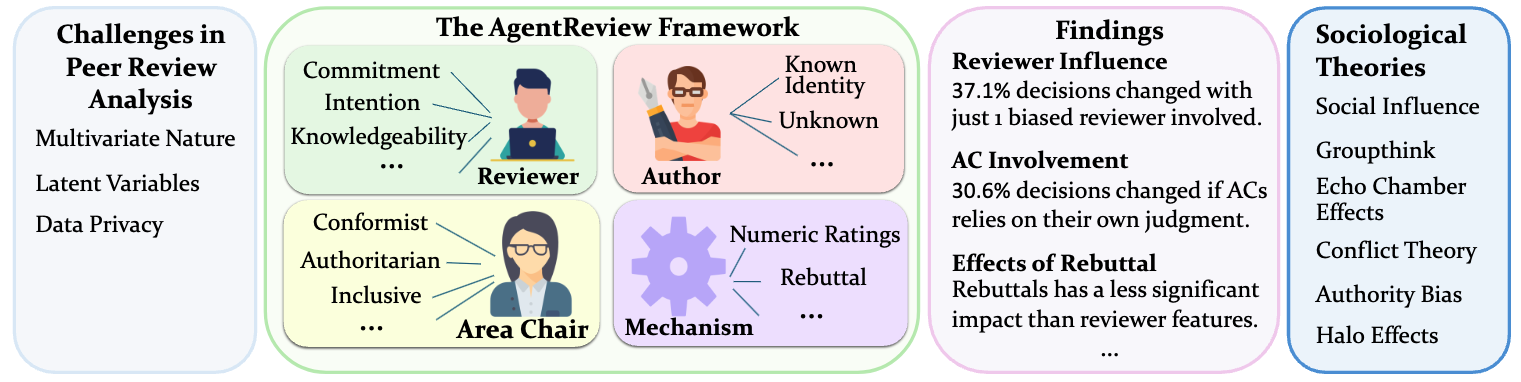

In [2]:
from IPython.display import Image
Image(filename="../static/img/Overview.png")

## Review Pipeline

The simulation adopts a structured, 5-phase pipeline (Section 2 in the [paper](https://arxiv.org/abs/2406.12708)):

* **I. Reviewer Assessment.** Each manuscript is evaluated by three reviewers independently.
* **II. Author-Reviewer Discussion.** Authors submit rebuttals to address reviewers' concerns;
* **III. Reviewer-AC Discussion.** The AC facilitates discussions among reviewers, prompting updates to their initial assessments.
* **IV. Meta-Review Compilation.** The AC synthesizes the discussions into a meta-review.
* **V. Paper Decision.** The AC makes the final decision on whether to accept or reject the paper, based on all gathered inputs.

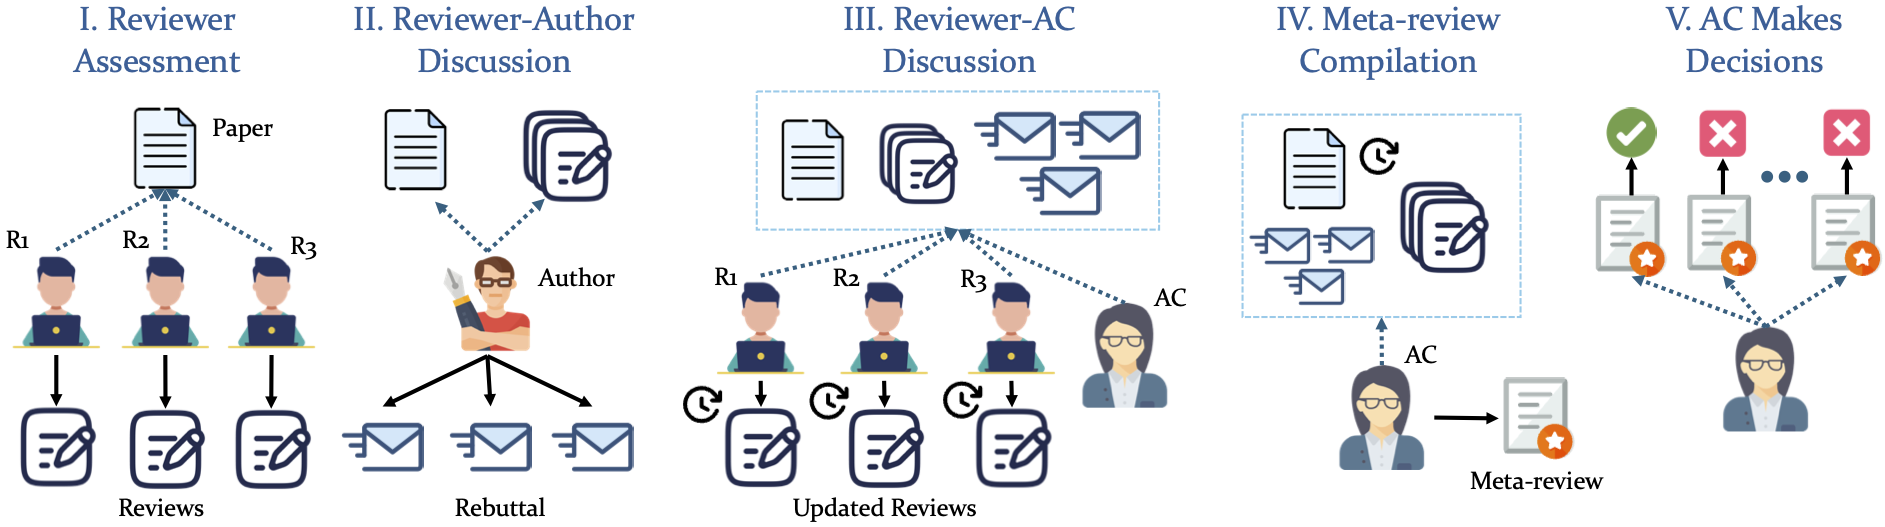

In [3]:
from IPython.display import Image
Image(filename="../static/img/ReviewPipeline.png")

In [ ]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
# Change the working directory to AgentReview
print(f"Changing the current working directory to {os.path.basename(os.getcwd())}")

In [ ]:
from argparse import Namespace

args = Namespace(openai_client_type=CLIENT_TYPE, 
          api_version='2023-03-15-preview', 
          ac_scoring_method='ranking', 
          conference='ICLR2024', 
          num_reviewers_per_paper=3,  
          ignore_missing_metareviews=False, 
          overwrite=False, 
          num_papers_per_area_chair=10, 
          model_name='gpt-4o', 
          output_dir='outputs', 
          max_num_words=16384, 
          visual_dir='outputs/visual', 
          device='cuda', 
          data_dir='./data', # Directory to all paper PDF
          acceptance_rate=0.32, 
          skip_logging=True, # If set, we do not log the messages in the console.
          task='paper_review')

In [ ]:
malicious_Rx1_setting = {
    "AC": [
        "BASELINE"
    ],

    "reviewer": [
        "malicious",
        "BASELINE",
        "BASELINE"
    ],

    "author": [
        "BASELINE"
    ],
    "global_settings":{
        "provides_numeric_rating": ['reviewer', 'ac'],
        "persons_aware_of_authors_identities": []
    }
}

all_settings = {"malicious_Rx1": malicious_Rx1_setting}
args.experiment_name = "malicious_Rx1"


`malicious_Rx1` means 1 reviewer is a malicious reviewer, and the other reviewers are default (i.e. `BASELINE`) reviewers.



## Reviews

Define the review pipeline

In [ ]:
import os
import sys
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "agentreview")))

from agentreview.environments import PaperReview
from agentreview.paper_review_arena import PaperReviewArena
from agentreview.paper_review_settings import get_experiment_settings
from agentreview.utility.experiment_utils import initialize_players
from agentreview.utility.utils import project_setup, get_paper_decision_mapping
    
from agentreview import const

In [ ]:
def review_one_paper(paper_id, setting):
    args.task = "paper_review"
    paper_decision = paper_id2decision[paper_id]

    experiment_setting = get_experiment_settings(paper_id=paper_id,
                                                 paper_decision=paper_decision,
                                                 setting=setting)
    print(f"Paper ID: {paper_id} (Decision in {args.conference}: {paper_decision})")

    players = initialize_players(experiment_setting=experiment_setting, args=args)

    player_names = [player.name for player in players]

    env = PaperReview(player_names=player_names, paper_decision=paper_decision, paper_id=paper_id,
                          args=args, experiment_setting=experiment_setting)

    arena = PaperReviewArena(players=players, environment=env, args=args)
    arena.launch_cli(interactive=False)


In [ ]:
sampled_paper_ids = [39]
sampled_paper_ids = [39, 247, 289, 400]

paper_id2decision, paper_decision2ids = get_paper_decision_mapping(args.data_dir, args.conference)

for paper_id in sampled_paper_ids:
    review_one_paper(paper_id, malicious_Rx1_setting)

Note: Sometimes metareview fails to load due to content filtering. We thus use `experimental_paper_ids` to track the paper IDs that were actually used in the experiment.

In [ ]:
from agentreview.environments import PaperDecision
from agentreview.utility.utils import project_setup, get_paper_decision_mapping, \
    load_metareview, load_llm_ac_decisions_as_array

args.task = "paper_decision"

sampled_paper_ids = [39, 247, 289, 400]

# Make sure the same set of papers always go through the same AC no matter which setting we choose
NUM_PAPERS = len(sampled_paper_ids)
order = np.random.choice(range(NUM_PAPERS), size=NUM_PAPERS, replace=False)


# Paper IDs we actually used in experiments
experimental_paper_ids = []

# For papers that have not been decided yet, load their metareviews
metareviews = []
print("Shuffling paper IDs")
sampled_paper_ids = np.array(sampled_paper_ids)[order]

for paper_id in sampled_paper_ids:
    # Since we are feeding a batch of paper, the paper_id and paper_decision fields 
    # are not specific to one paper, thus left None
    experiment_setting = get_experiment_settings(paper_id=None,
                                                 paper_decision=None,
                                                 setting=all_settings[args.experiment_name])

    # Load meta-reviews
    metareview = load_metareview(output_dir=args.output_dir, paper_id=paper_id,
                                 experiment_name=args.experiment_name,
                                 model_name=args.model_name, conference=args.conference)

    if metareview is None:

        print(f"Metareview for {paper_id} does not exist. This may happen because the conversation is "
              f"completely filtered out due to content policy. "
              f"Loading the BASELINE metareview...")

        metareview = load_metareview(paper_id=paper_id, experiment_name="BASELINE",
                                     model_name=args.model_name, conference=args.conference)
        print(metareview)

    if metareview is not None:
        metareviews += [metareview]
        experimental_paper_ids += [paper_id]

args.num_papers_per_area_chair = 2
num_batches = len(experimental_paper_ids) // args.num_papers_per_area_chair

for batch_index in range(num_batches):

    players = initialize_players(experiment_setting=experiment_setting, args=args)
    player_names = [player.name for player in players]

    if batch_index >= num_batches - 1:  # Last batch. Include all remaining papers
        batch_paper_ids = experimental_paper_ids[batch_index * args.num_papers_per_area_chair:]

    else:
        batch_paper_ids = experimental_paper_ids[batch_index * args.num_papers_per_area_chair: (batch_index + 1) *
                                                                                               args.num_papers_per_area_chair]

    env = PaperDecision(player_names=player_names, paper_ids=batch_paper_ids,
                        metareviews=metareviews,
                        experiment_setting=experiment_setting, ac_scoring_method=args.ac_scoring_method)

    arena = PaperReviewArena(players=players, environment=env, args=args, global_prompt=const.GLOBAL_PROMPT)
    arena.launch_cli(interactive=False)


In [ ]:
decisions, paper_ids = load_llm_ac_decisions_as_array(output_dir=args.output_dir, conference=args.conference, 
                                                      model_name=args.model_name,
                                                      ac_scoring_method=args.ac_scoring_method,
                                                      experiment_name=args.experiment_name,
                                                      acceptance_rate=args.acceptance_rate,
                                                      num_papers_per_area_chair=args.num_papers_per_area_chair)

In [ ]:
for paper_id, decision in zip(paper_ids, decisions):
    print(f"{paper_id}\t{'Accept' if decision else 'Reject'}")